In [2]:
import numpy as np
import tensorflow as tf 

import matplotlib.pyplot as plt 
%matplotlib inline 

np.random.seed(0)
tf.set_random_seed(0)


In [3]:
import input_data 
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
n_samples = mnist.train.num_examples

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [7]:
def xavier_init(fan_in,fan_out,constant=1):
    low = -constant*np.sqrt(6.0/(fan_in+fan_out))
    high = constant*np.sqrt(6.0/(fan_in+fan_out))
    return tf.random_uniform((fan_in,fan_out),minval=low,maxval=high,dtype=tf.float32)
    

In [58]:
class VariationalAutoencoder(object):
    
    def __init__(self,network_architecture,transfer_fct=tf.nn.softplus,
                learning_rate=0.001,batch_size=100):
        self.network_architecture=network_architecture
        self.transfer_fct=transfer_fct
        self.learning_rate=learning_rate
        self.batch_size=batch_size
        
        #tf graph input
        self.x = tf.placeholder(tf.float32, [None,network_architecture["n_input"]])
        
        #crate autoencoder 
        self._create_network()
        
        self._create_loss_optimizer()
        
        #initialize tf variables 
        init = tf.global_variables_initializer()
        
        #launch session
        self.sess = tf.InteractiveSession()
        self.sess.run(init)
        
        
    def _create_network(self):
        
        #initialize weights and biases 
        network_weights = self._initialize_weights(**self.network_architecture)
        
        #recognition network to determine mean and log variance of gaussian in latent space 
        self.z_mean, self.z_log_sigma_sq = self._recognition_network(
            network_weights["weights_recog"],network_weights["biases_recog"])
        
        #draw a sample from the gaussian distribution 
        n_z = self.network_architecture["n_z"]
        eps = tf.random_normal((self.batch_size,n_z),0,1,dtype=tf.float32)
        
        #z= u + sigma*epsilon 
        self.z = tf.add(self.z_mean,tf.multiply(tf.sqrt(tf.exp(self.z_log_sigma_sq)),eps))
        
        #use generator to determine of bernoulli distribution of reconstructed input 
        self.x_reconstr_mean = self._generator_network(network_weights["weights_gener"],
                                                       network_weights["biases_gener"])
        
        
    def _initialize_weights(self,n_hidden_recog_1,n_hidden_recog_2,n_hidden_gener_1,n_hidden_gener_2,
                           n_input,n_z):
        all_weights = dict()
        all_weights["weights_recog"] = {
            'h1': tf.Variable(xavier_init(n_input,n_hidden_recog_1)),
            'h2': tf.Variable(xavier_init(n_hidden_recog_1,n_hidden_recog_2)),
            'out_mean' : tf.Variable(xavier_init(n_hidden_recog_2,n_z)),
            'out_log_sigma' : tf.Variable(xavier_init(n_hidden_recog_2,n_z))} 
        
        all_weights["biases_recog"]={
            'b1': tf.Variable(tf.zeros([n_hidden_recog_1],dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_recog_2],dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_z],dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_z], dtype=tf.float32))}
        all_weights["weights_gener"] = {
            'h1': tf.Variable(xavier_init(n_z,n_hidden_gener_1)),
            'h2': tf.Variable(xavier_init(n_hidden_gener_1,n_hidden_gener_2)),
            'out_mean' : tf.Variable(xavier_init(n_hidden_gener_2,n_input)),
            'out_log_sigma' : tf.Variable(xavier_init(n_hidden_gener_2,n_input))} 
        
        all_weights["biases_gener"]={
            'b1': tf.Variable(tf.zeros([n_hidden_gener_1],dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_gener_2],dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_input],dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_input], dtype=tf.float32))}
        
        return all_weights
    
    
    def _recognition_network(self,weights,biases):
        
        #print(self.x.shape)
        #probabilistic encoder which maps inputs to a a gaussian space which can be parametrized 
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.x,weights['h1']),biases['b1']))
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1,weights['h2']),biases['b2']))
        
        #print(layer_1.shape)
        #print(layer_2.shape)
        z_mean = tf.add(tf.matmul(layer_2,weights['out_mean']),biases['out_mean'])
        z_log_sigma_sq = tf.add(tf.matmul(layer_2,weights['out_log_sigma']),biases['out_log_sigma'])
        
        #print(z_mean.shape)
        #print(z_log_sigma_sq.shape)
        return (z_mean,z_log_sigma_sq)
    
    
    def _generator_network(self,weights,biases):
        
        #print(self.z.shape)
        #probabilistic decoder which maps latent space to a a bernoulli distribution which can be parametrized 
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.z,weights['h1']),biases['b1']))
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1,weights['h2']),biases['b2']))
        
        #print(layer_2.shape)
        x_reconstr_mean = tf.nn.sigmoid(tf.add(tf.matmul(layer_2,weights['out_mean']),
                                                 biases['out_mean']))
              
        return x_reconstr_mean
    
    def _create_loss_optimizer(self):
        
        #the loss consists of 2 terms 
        #the reconstruction loss P(x/z)
        
        reconstr_loss = -tf.reduce_sum(self.x*tf.log(1e-10 + self.x_reconstr_mean) + (1-self.x)*tf.log(1e-10 +
                                                        (1-self.x_reconstr_mean)),1)
        
        #K-L divergence between the posterior and the prior of the latent space 
        latent_loss = -0.5*tf.reduce_sum(1 + self.z_log_sigma_sq - tf.square(self.z_mean) - 
                                         tf.exp(self.z_log_sigma_sq), 1)
        
        #average over batch 
        self.cost = tf.reduce_mean(reconstr_loss + latent_loss)
        
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)
        
        
    def partial_fit(self,X):
        #train model on minibatch of input data and return cost 
        
        opt,cost = self.sess.run((self.optimizer,self.cost),feed_dict={self.x:X})
        
        return cost 
    
    def transform(self,X):
        #return mean of latent space (alternatively we can sample from latent space)
        
        return self.sess.run(self.z_mean,feed_dict={self.x:X})
    
    def generate(self,z_mu=None):
        
        if z_mu is None:
            z_mu = np.random.normal(size=self.network_architecture["n_z"])
            
        return self.sess.run(self.x_reconstr_mean,feed_dict={self.z:z_mu})
    
    def reconstruct(self,X):
        #use VAE to reconstruct given data 
        
        return self.sess.run(self.x_reconstr_mean,feed_dict={self.x:X})
    
    
                    

In [50]:
print(n_samples)

55000


In [59]:
def train(network_architecture,learning_rate=0.001,batch_size=100,training_epochs=5,display_step=50):
    
    vae = VariationalAutoencoder(network_architecture,learning_rate=learning_rate,batch_size=batch_size)
    
    for epoch in range(training_epochs):
        avg_cost = 0
        
        total_batch = int(n_samples/batch_size)
        
        for i in range(total_batch):
            batch_xs,_ = mnist.train.next_batch(batch_size)
            
            #print(batch_xs.shape)
            cost = vae.partial_fit(batch_xs)
            
            avg_cost += cost/n_samples * batch_size
            
            if (i % display_step == 0):
                print('batch:','%d' %(i),"cost:",'%0.2f' %(cost/batch_size))
                
                
    return vae 
            
    

In [60]:
network_architecture = dict(n_hidden_recog_1 = 500,
     n_hidden_recog_2 = 500,
     n_hidden_gener_1 = 500,
     n_hidden_gener_2 = 500,
     n_input = 784,
     n_z = 20)

vae = train(network_architecture)
print("training done")

batch: 0 cost: 6.11
batch: 50 cost: 2.03
batch: 100 cost: 1.92
batch: 150 cost: 1.94
batch: 200 cost: 1.84
batch: 250 cost: 1.72
batch: 300 cost: 1.65
batch: 350 cost: 1.56
batch: 400 cost: 1.46
batch: 450 cost: 1.49
batch: 500 cost: 1.47
batch: 0 cost: 1.34
batch: 50 cost: 1.40
batch: 100 cost: 1.36
batch: 150 cost: 1.36
batch: 200 cost: 1.23
batch: 250 cost: 1.34
batch: 300 cost: 1.26
batch: 350 cost: 1.26
batch: 400 cost: 1.18
batch: 450 cost: 1.27
batch: 500 cost: 1.24
batch: 0 cost: 1.20
batch: 50 cost: 1.13
batch: 100 cost: 1.16
batch: 150 cost: 1.20
batch: 200 cost: 1.17
batch: 250 cost: 1.20
batch: 300 cost: 1.17
batch: 350 cost: 1.18
batch: 400 cost: 1.22
batch: 450 cost: 1.19
batch: 500 cost: 1.22
batch: 0 cost: 1.17
batch: 50 cost: 1.08
batch: 100 cost: 1.19
batch: 150 cost: 1.20
batch: 200 cost: 1.14
batch: 250 cost: 1.11
batch: 300 cost: 1.14
batch: 350 cost: 1.14
batch: 400 cost: 1.14
batch: 450 cost: 1.08
batch: 500 cost: 1.18
batch: 0 cost: 1.12
batch: 50 cost: 1.11
bat

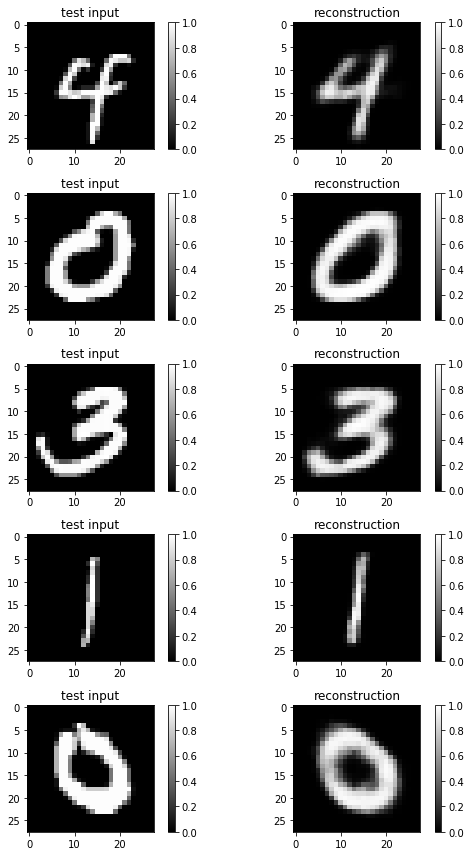

In [61]:
x_sample = mnist.test.next_batch(100)[0]
x_reconstruct = vae.reconstruct(x_sample)

plt.figure(figsize=(8,12))
for i in range(5):
    plt.subplot(5,2,2*i+1)
    plt.imshow(x_sample[i].reshape(28,28),vmin=0,vmax=1,cmap="gray")
    plt.title("test input")
    plt.colorbar()
    
    plt.subplot(5,2,2*i+2)
    plt.imshow(x_reconstruct[i].reshape(28,28),vmin=0,vmax=1,cmap="gray")
    plt.title("reconstruction")
    plt.colorbar()
    
plt.tight_layout()


In [62]:
network_architecture = dict(n_hidden_recog_1 = 500,
     n_hidden_recog_2 = 500,
     n_hidden_gener_1 = 500,
     n_hidden_gener_2 = 500,
     n_input = 784,
     n_z = 2)

vae = train(network_architecture)
print("training done")

batch: 0 cost: 6.01
batch: 50 cost: 2.09
batch: 100 cost: 2.00
batch: 150 cost: 1.93
batch: 200 cost: 1.96
batch: 250 cost: 1.90
batch: 300 cost: 1.94
batch: 350 cost: 1.84
batch: 400 cost: 1.67
batch: 450 cost: 1.78
batch: 500 cost: 1.74
batch: 0 cost: 1.75
batch: 50 cost: 1.72
batch: 100 cost: 1.75
batch: 150 cost: 1.64
batch: 200 cost: 1.64
batch: 250 cost: 1.69
batch: 300 cost: 1.59
batch: 350 cost: 1.65
batch: 400 cost: 1.68
batch: 450 cost: 1.58
batch: 500 cost: 1.63
batch: 0 cost: 1.66
batch: 50 cost: 1.71
batch: 100 cost: 1.57
batch: 150 cost: 1.52
batch: 200 cost: 1.59
batch: 250 cost: 1.65
batch: 300 cost: 1.61
batch: 350 cost: 1.63
batch: 400 cost: 1.56
batch: 450 cost: 1.61
batch: 500 cost: 1.61
batch: 0 cost: 1.52
batch: 50 cost: 1.63
batch: 100 cost: 1.55
batch: 150 cost: 1.60
batch: 200 cost: 1.53
batch: 250 cost: 1.61
batch: 300 cost: 1.57
batch: 350 cost: 1.57
batch: 400 cost: 1.62
batch: 450 cost: 1.60
batch: 500 cost: 1.59
batch: 0 cost: 1.64
batch: 50 cost: 1.59
bat

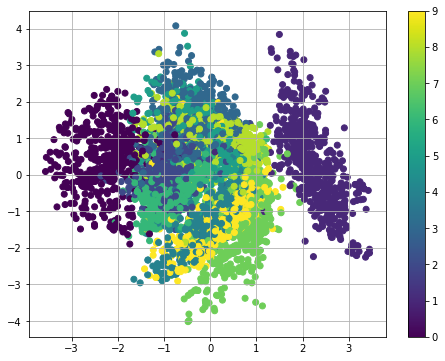

In [68]:
x_sample,y_sample = mnist.test.next_batch(5000)
z_mu = vae.transform(x_sample)
plt.figure(figsize=(8,6))
#print(np.argmax(y_sample,1))
#plt.scatter(z_mu[:,0],z_mu[:,1],c=np.argmax(y_sample,1))
plt.scatter(z_mu[:,0],z_mu[:,1],c=np.argmax(y_sample,1))
plt.colorbar()
plt.grid()

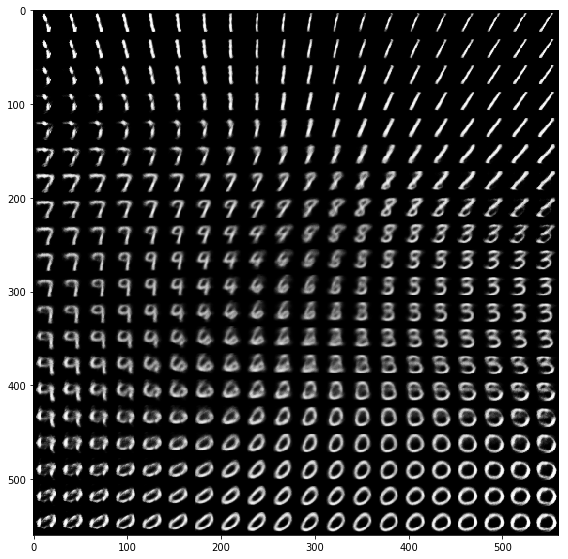

In [73]:
nx = ny = 20
x_values = np.linspace(-3,3,nx)
y_values = np.linspace(-3,3,ny)

canvas = np.empty((28*nx,28*ny))
for i,xi in enumerate(x_values):
    for j,yi in enumerate(y_values):
        z_mu = np.array([[xi,yi]]*vae.batch_size)
        #print(z_mu.shape)
        x_mean = vae.generate(z_mu)
        canvas[(nx-i-1)*28:(nx-i)*28, 28*j:(j+1)*28] = x_mean[0].reshape(28,28)
        
plt.figure(figsize=(8,10))
Xi,Yi = np.meshgrid(x_values,y_values)
plt.imshow(canvas,origin="upper",cmap="gray")
plt.tight_layout()


